# Setup Inicial

In [33]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random
import os
import inspect
import pathlib

#Essentials

import IPython
import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

import qiskit
from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *

## Mitiq 

from mitiq import zne


%matplotlib widget
#%matplotlib inline

In [2]:
# Backends

provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

# Setup inicial do problema

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

# Criando Circuito Aria - AWS

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

# Criando Circuito Brisbane - IBM

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [3]:
def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [4]:

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)         
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# ZNE

In [121]:
def circuit_folding(circuit, noise_factor):
    
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
    
    circuito = circuit.copy()
    
    for a in range(n):
        
        inverse = circuit.inverse()
        
        identity = inverse.compose(circuit)
        
        circuito = circuito.compose(identity)
    
    if s != 0:
        
        circuito_parcial = QuantumCircuit(*circuito.qregs, *circuito.cregs)
                
        for instr in circuito.data[-s:]:
            
            circuito_parcial.append(instr[0], instr[1], instr[2])
    
        inverse = circuito_parcial.inverse()
        
        identity = inverse.compose(circuito_parcial)
        
        circuito = circuito.compose(identity)
    
    return circuito

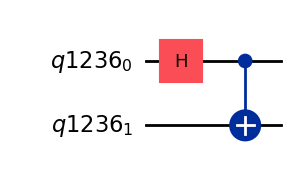

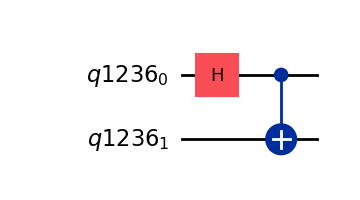

In [143]:
qubits = qiskit.QuantumRegister(2)
circuit_temp = qiskit.QuantumCircuit(qubits)
circuit_temp.h(0)
circuit_temp.cx(0, 1)

circuit_temp.draw('mpl')

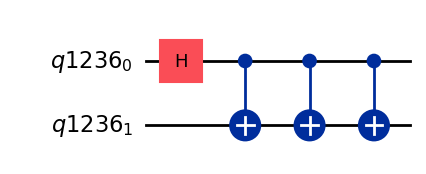

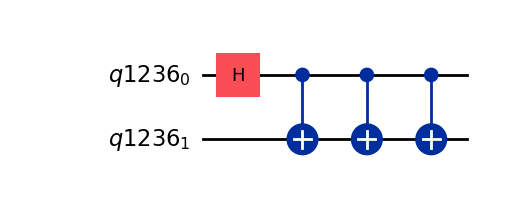

In [145]:
circuit_folding(circuit_temp, 2).draw("mpl")

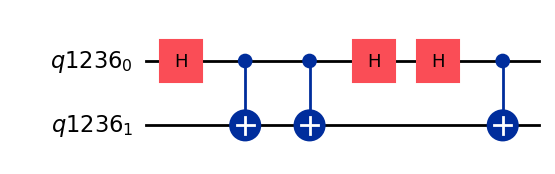

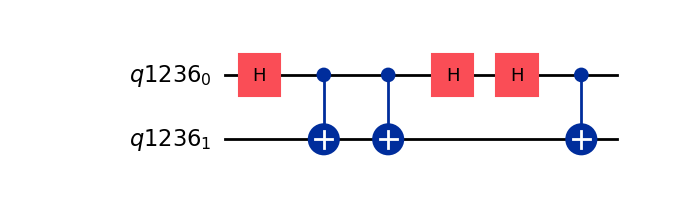

In [146]:
circuit_folding(circuit_temp, 3).draw("mpl")

In [124]:
def func(a):
    circuito_mitiq = zne.scaling.fold_global(circuit_temp, scale_factor=a)
    circuito_func = circuit_folding(circuit_temp, a)

    print(f"Lambda = {a}\n\nCircuito Mitiq :\n{circuito_mitiq}\n\nCircuito Função :\n{circuito_func}")

    print("--------------------------------")


for a in range(1, 10):
    func(a)

Lambda = 1

Circuito Mitiq :
         ┌───┐     
q1228_0: ┤ H ├──■──
         └───┘┌─┴─┐
q1228_1: ─────┤ X ├
              └───┘

Circuito Função :
         ┌───┐     
q1228_0: ┤ H ├──■──
         └───┘┌─┴─┐
q1228_1: ─────┤ X ├
              └───┘
--------------------------------
Lambda = 2

Circuito Mitiq :
         ┌───┐               
q1228_0: ┤ H ├──■────■────■──
         └───┘┌─┴─┐┌─┴─┐┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├┤ X ├
              └───┘└───┘└───┘

Circuito Função :
         ┌───┐               
q1228_0: ┤ H ├──■────■────■──
         └───┘┌─┴─┐┌─┴─┐┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├┤ X ├
              └───┘└───┘└───┘
--------------------------------
Lambda = 3

Circuito Mitiq :
         ┌───┐          ┌───┐┌───┐     
q1228_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──
         └───┘┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├──────────┤ X ├
              └───┘└───┘          └───┘

Circuito Função :
         ┌───┐          ┌───┐┌───┐     
q1228_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──
         └

In [130]:
#arrumando a quantidade de qubits do circuito ibm:

new_circuit = QuantumCircuit(4)

for gate in circuito.data:

    if all(circuito.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito.qubits.index(qubit) for qubit in gate[1]])

circuito_pequeno = new_circuit

In [135]:
print(circuit_folding(circuito_pequeno, 7).depth())
print(circuito_pequeno.depth())

518
74
